In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Book dictionary
books = {
    "stone_B1_28": "Joly (1893); Vol. 1-28",
    "stone_B29_56": "Joly (1893); Vol. 29-56",
    "stone_F57_80": "McHugh & McHugh (1958); Vol. 57-80",
    "stone_Y1_24": "Yang & Yang (1980); Vol. 1-24",
    "stone_Y25_48": "Yang & Yang (1980); Vol. 25-48",
    "stone_Y49_72": "Yang & Yang (1980); Vol. 49-72",
    "stone_Y73_96": "Yang & Yang (1980); Vol. 73-96",
    "stone_Y97_120": "Yang & Yang (1980); Vol. 97-120",
    "stone_H1_24": "Hawkes & Minford (1986); Vol. 1-24",
    "stone_H25_48": "Hawkes & Minford (1986); Vol. 25-48",
    "stone_H49_72": "Hawkes & Minford (1986); Vol. 49-72",
    "stone_H73_96": "Hawkes & Minford (1986); Vol. 73-96",
    "stone_H97_120": "Hawkes & Minford (1986); Vol. 97-120",
    "stone_G1_24": "OpenAI o3-mini, 2025; Vol. 1-24",
    "stone_G25_48": "OpenAI o3-mini, 2025; Vol. 25-48",
    "stone_G49_72": "OpenAI o3-mini, 2025; Vol. 49-72",
    "stone_G73_96": "OpenAI o3-mini, 2025; Vol. 73-96",
    "stone_G97_120": "OpenAI o3-mini, 2025; Vol. 97-120",
}

# Load JSON data
pos_dist_dict_book = {}
for book in books:
    with open(f"results/embed/{book}.json", "r") as file:
        pos_dist_dict_book[book] = json.load(file)

In [3]:
classes = {
    "intj": "Interjection (Wow, Ha)",
    "propn": "Proper Noun (Harry, UK)",
    "noun": "Noun (apple, car)",
    "verb": "Verb (run, eat)",
    "adj": "Adjective (happy, tall)",
    "adv": "Adverb (quickly, softly)",
    "sconj": "Subord. Conj. (if, as)",
    "aux": "Auxiliary Verb (is, has)",
    "prop": "Preposition (in, of)",
    "pron": "Pronoun (she, they)",
    "cconj": "Coord. Conj. (and, or)",
    "det": "Determiner (the, an)"
}

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.manifold import TSNE

In [5]:
X = np.array([[pos_dist_dict_book[book][k] for k in classes.keys()] for book in books])
label_true = np.array([0, 0,
                       1,
                       2, 2, 2, 2, 2,
                       3, 3, 3, 3, 3,
                       4, 4, 4, 4, 4])

# Initialize and fit KMeans
labels_pred = []
scores = []
for i in range(100):
    model = KMeans(n_clusters=5,
                   init='k-means++',
                   random_state=i)
    model.fit(X)
    labels_pred.append(model.labels_)
    scores.append(v_measure_score(label_true, model.labels_))
scores = np.array(scores)

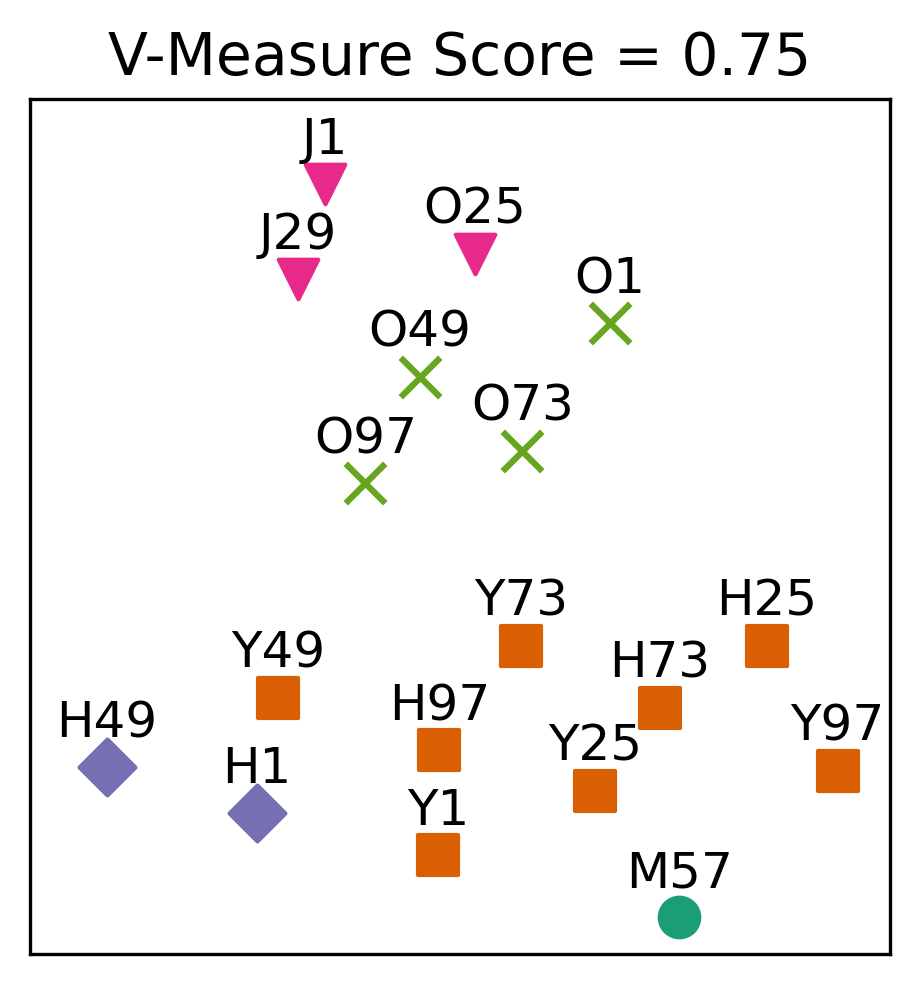

In [12]:
# Show best
labels_pred_show = labels_pred[np.argmax(scores)]

# Make sure GPT is last
gpt_label = labels_pred_show[-1]
labels_pred_show_copy = labels_pred_show.copy()
labels_pred_show[labels_pred_show_copy == gpt_label] = 4
labels_pred_show[labels_pred_show_copy == 4] = gpt_label

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=9)  # Perplexity adjusted for small dataset
X_tsne = tsne.fit_transform(X)

# Plot t-SNE visualization with KMeans labels
plt.figure(dpi=300, figsize=(3.7, 3.7))
shapes = ['o', 's', 'D', 'v', 'x', "p", "P"]
for i, label in enumerate(labels_pred_show):
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], c=[plt.cm.Dark2(label)],
                s=90, marker=shapes[label])
    plt.text(X_tsne[i, 0], X_tsne[i, 1] + 5,
             list(books.keys())[i][6:].split("_")[0].replace("F", "M").replace("G", "O").replace("B", "J"),
             ha="center", va="bottom", fontsize=12)

ax = plt.gca()
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
ax.set_xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.02 * (x_max - x_min))
ax.set_ylim(y_min, y_max + 0.06 * (y_max - y_min))
# plt.text(x_min + 0.1 * (x_max - x_min), y_min + 0.02 * (y_max - y_min), "t-SNE X", fontsize=14)
# plt.text(x_min - 0.04 * (x_max - x_min), y_min + 0.15 * (y_max - y_min), "t-SNE Y", fontsize=14,
#          rotation=90, ha="right")
plt.xticks([])
plt.yticks([])

plt.title(f"V-Measure Score = {max(scores):.2f}", fontsize=14)
plt.savefig(f"results/figs/kmeans_embed.pdf", bbox_inches="tight", pad_inches=0.02)